In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy import stats

In [71]:
filepath = 'data/titanic/train.csv'
train = pd.read_csv(filepath)
filepath = 'data/titanic/test.csv'
test = pd.read_csv(filepath)

# Problem 1 - Classification Model 1:
---

After doing some initial analysis of the various input features and target label,
(show your work on this), run an experiment in Python using any of the techniques you learned about in lectures/materials/background reading. Clearly
show your code in your IPython notebook file (ultimately submitted as a pdf
file) along with the necessary comments showing the input features used in
your model and the hyperparameter settings (which depend on the model technique you are using). For example, if you’re using a random forest, one of
the hyperparameters would be the maximum tree depth, (there are many other
hyperparameter settings, as well).

• Pre-processing Techniques: Feature selection, feature creation, dimensionality reduction, noise reduction, attribute discretization, . . .

• Classification Techniques: decision trees for classification, rule-based classifiers, instance-based classifiers (including KNN’s), Bayesian classifiers,
artificial neural networks (ANN’s), support vector machines (SVM’s), and
finally, and perhaps most importantly, ensemble methods (bagging, boosting, random forests) for combining the methods listed above.

## Provide code/comments/appropriate description for the following:
---

### 1. Code and results for any preprocessing/visulization of input features and label (passenger survivorship).

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# print(f'There are {train.shape[0]} samples and {train.shape[1]} features in the training set.')
# print('------------------------------------')
# print('Results of train.info():')
# print(train.info())
# print('------------------------------------')
# print('Results of train.describe():')
# print(train.describe())

All of the feature datatypes seem to make sense. The 'Cabin' feature is 77% null so I will likely remove/transform that. The 'Age' feature is ~20% null so that will also need to be dealt with. 

General observations about the feature stats: The mean age is lower than I would have imagined. I'm also surprised that 'SibSp' stats were so low. I imagined that most people were on the Titanic with a spouse! The stats for the 'Parch' (number of parents or children aboard) feature are very low. From the little I know of the Titanic it didn't seem like something people would go on with their parents/kids, so this isn't particularly surprising. Still, I'm interested to see the details.

#### Dealing with Null Values

I'm taking different approaches to treating the nulls in 'Cabin' and 'Age'. Since 'Cabin' is mostly null I will just drop the column. 

In [ ]:
train.drop('Cabin', axis=1, inplace=True)

For 'Age' I will fill the nulls. I'd rather fill them with group means than the col mean so I'll see if there is a good variable to group 'Age' by.

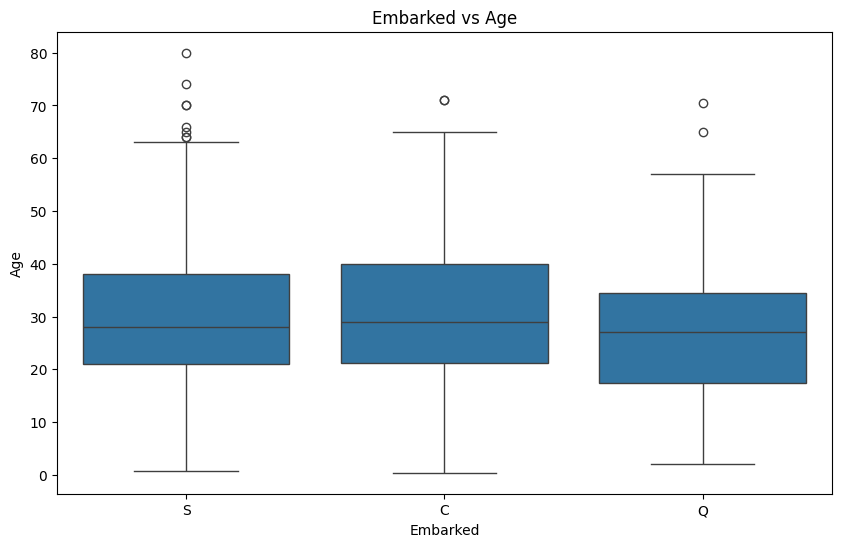

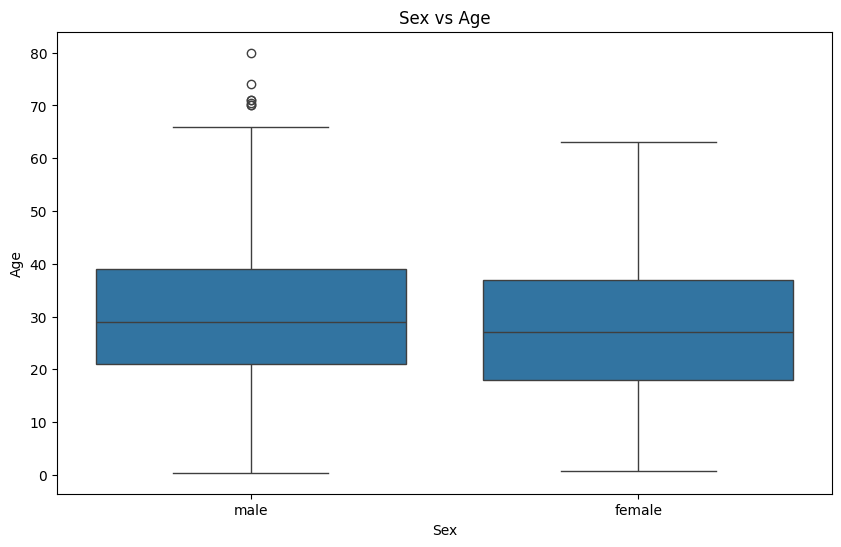

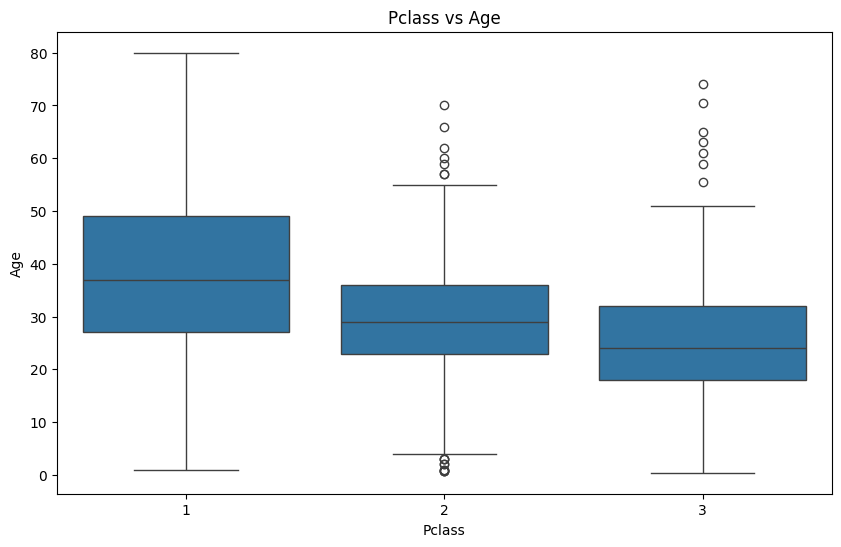

In [62]:
cols = ['Embarked', 'Sex', 'Pclass']
for col in cols:
    plt.figure(figsize=(10, 6))
    x= col
    y = 'Age'
    sns.boxplot(x=x, y=y, data=train)
    plt.title(f'{x} vs {y}')
    plt.show()

Based on this I think 'Pclass' makes sense as a grouping variable for 'Age'.

In [69]:
train['Age'] = train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))

#### EDA Continued

In [5]:
value_counts = train['Parch'].value_counts()
for i in range(len(value_counts)):
    print(f'{value_counts.iloc[i]} passengers had {value_counts.index[i]} parents or children aboard.')

678 passengers had 0 parents or children aboard.
118 passengers had 1 parents or children aboard.
80 passengers had 2 parents or children aboard.
5 passengers had 5 parents or children aboard.
5 passengers had 3 parents or children aboard.
4 passengers had 4 parents or children aboard.
1 passengers had 6 parents or children aboard.


Plotting first the numerical then the categorical features for more details on what we saw in .describe().

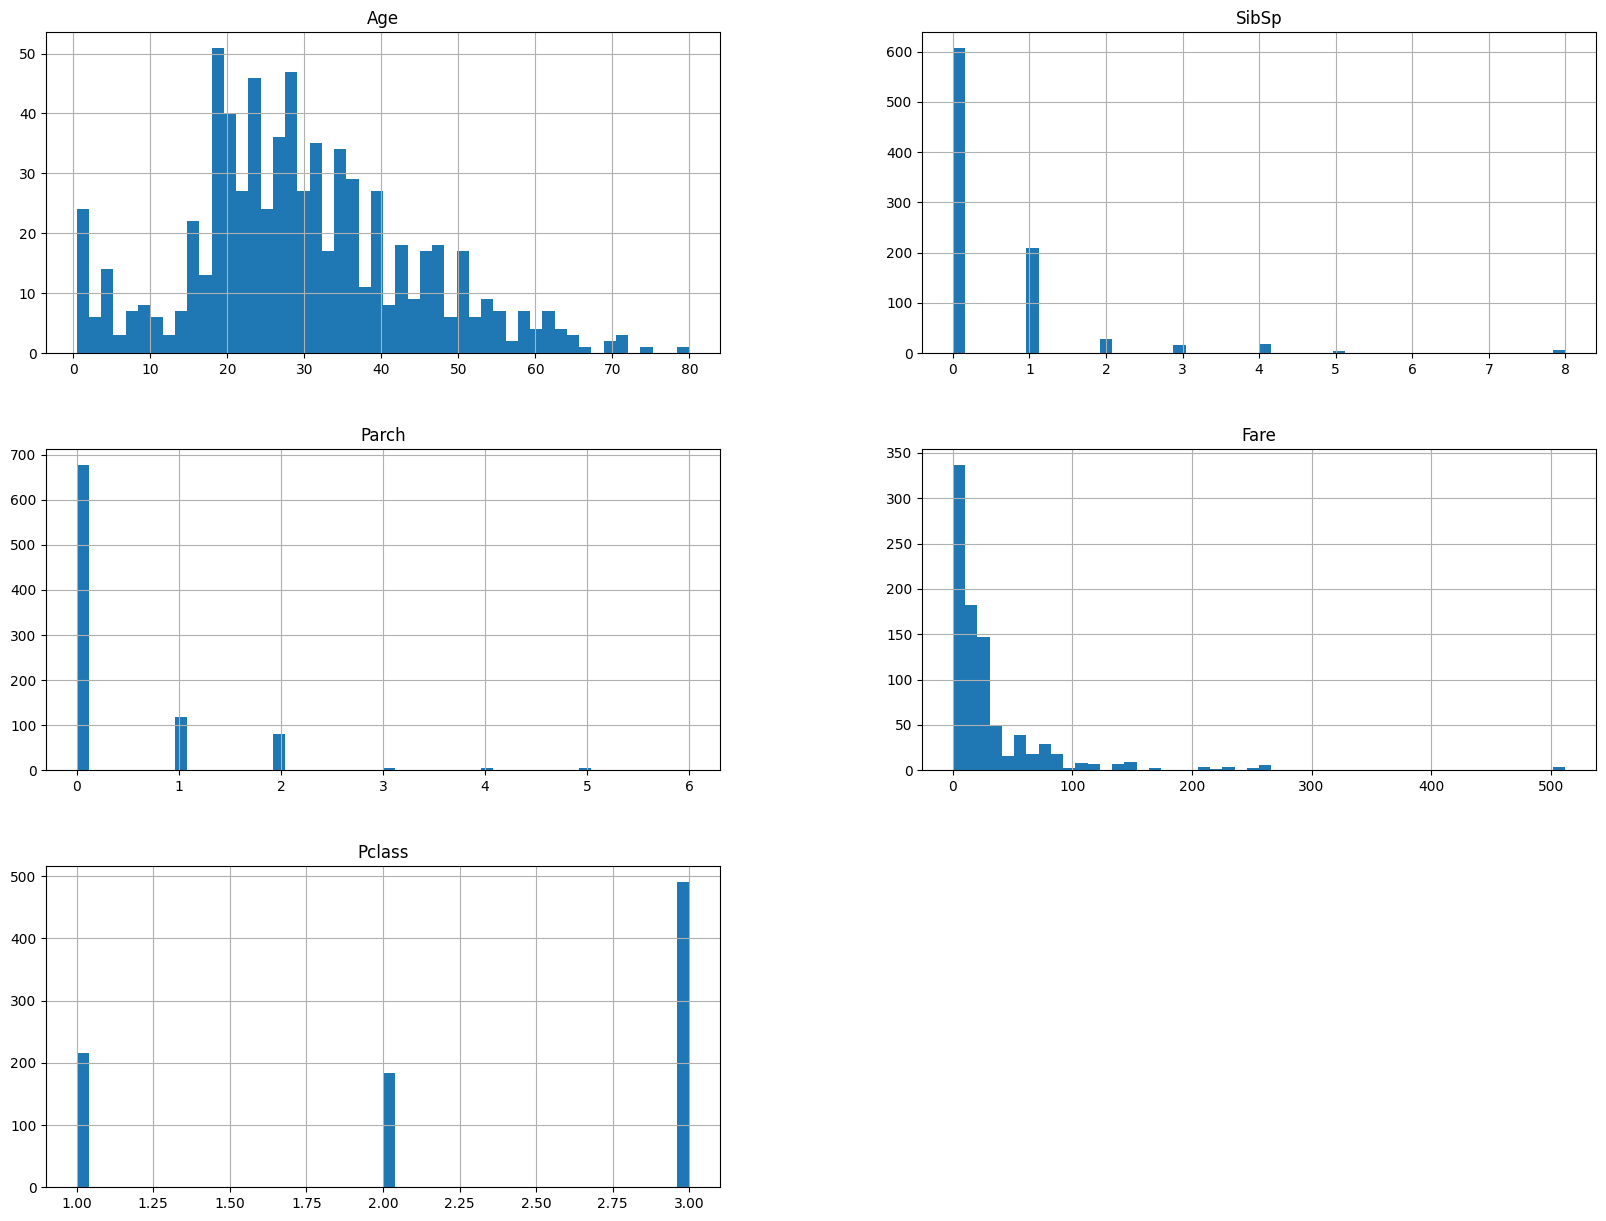

In [72]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train[numerical_features].hist(bins=50, figsize=(20, 15))
plt.show()

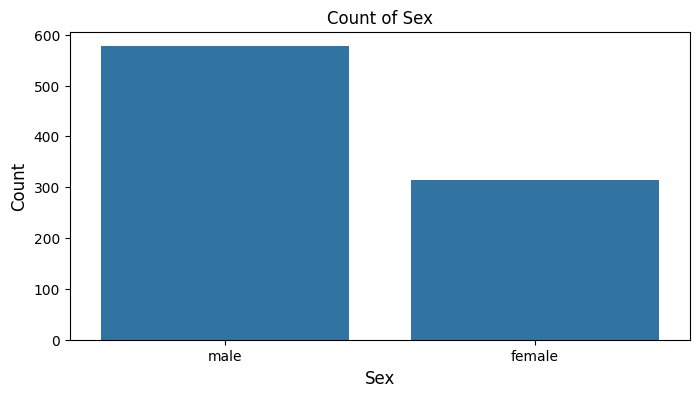

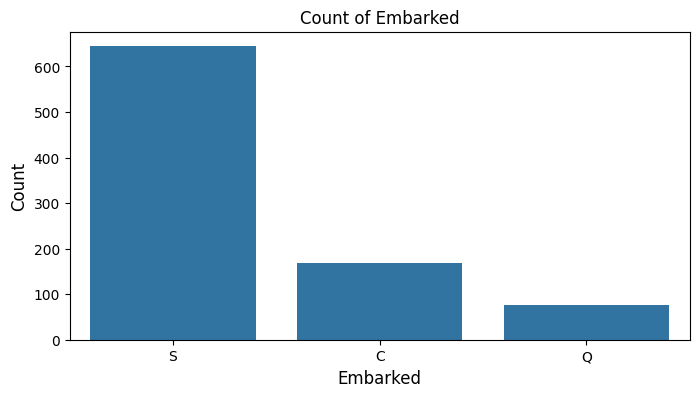

In [7]:
categorical_features = ['Sex', 'Embarked']

for col in train[categorical_features].columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=train)
    plt.title(f'Count of {col}')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

In [8]:
# le = LabelEncoder()
# feature = 'Sex'
# feature_binary = le.fit_transform(train[feature])

# feature_binary = (feature_binary == 0).astype(int)
# train['Female'] = feature_binary

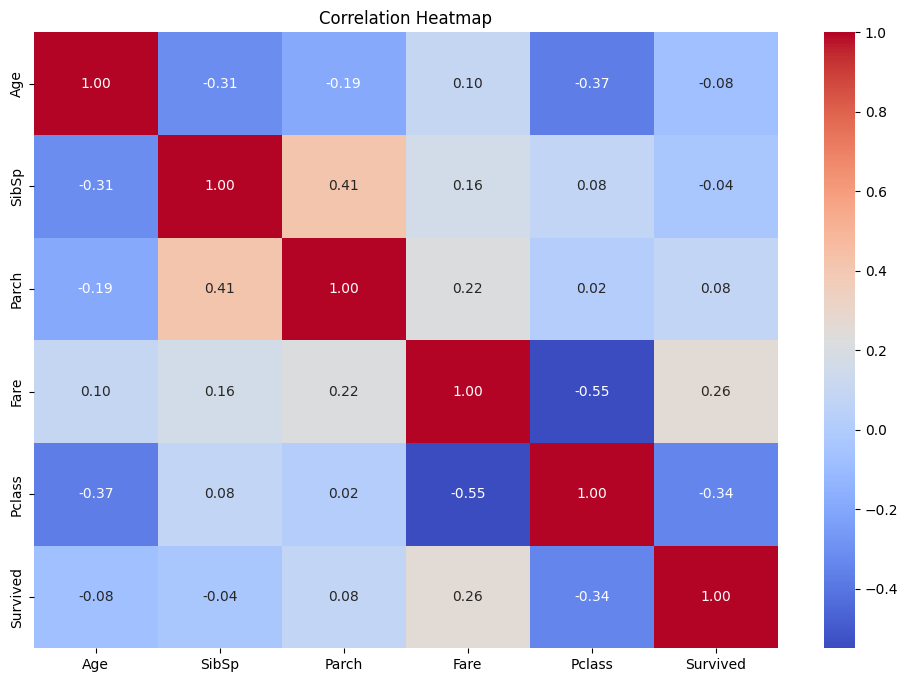

In [9]:
corr_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Survived',]
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We can see that 'Fare' and 'Pclass' have a negative correlation. Might be worth combining those into one feature.

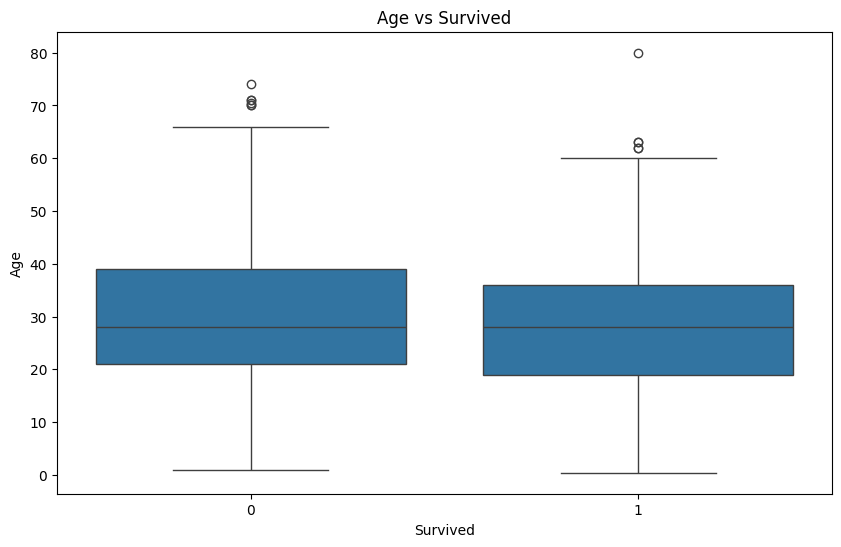

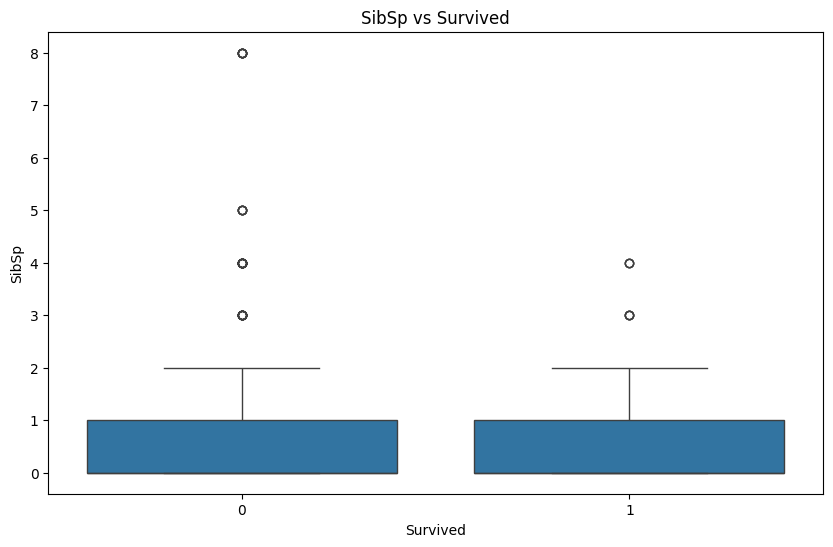

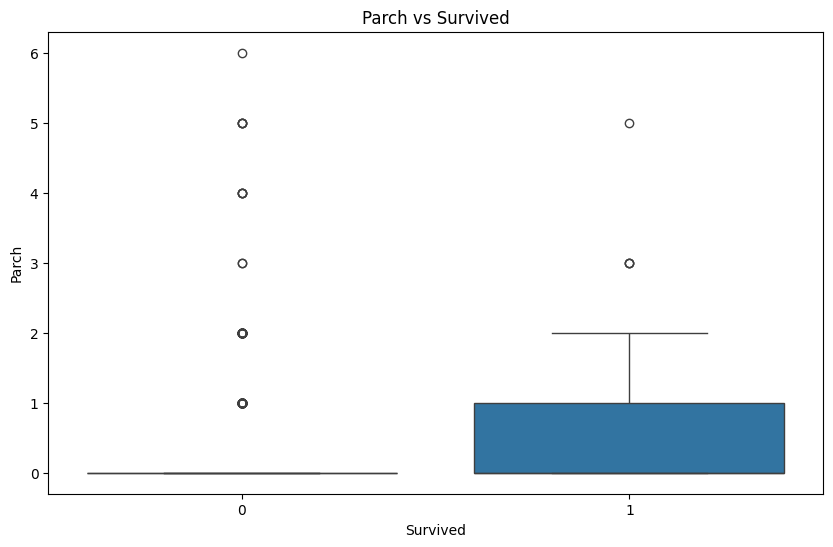

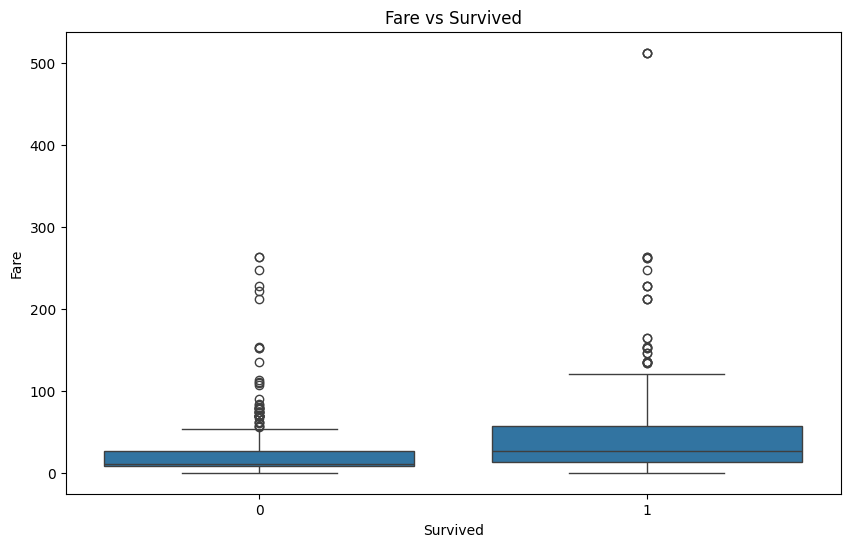

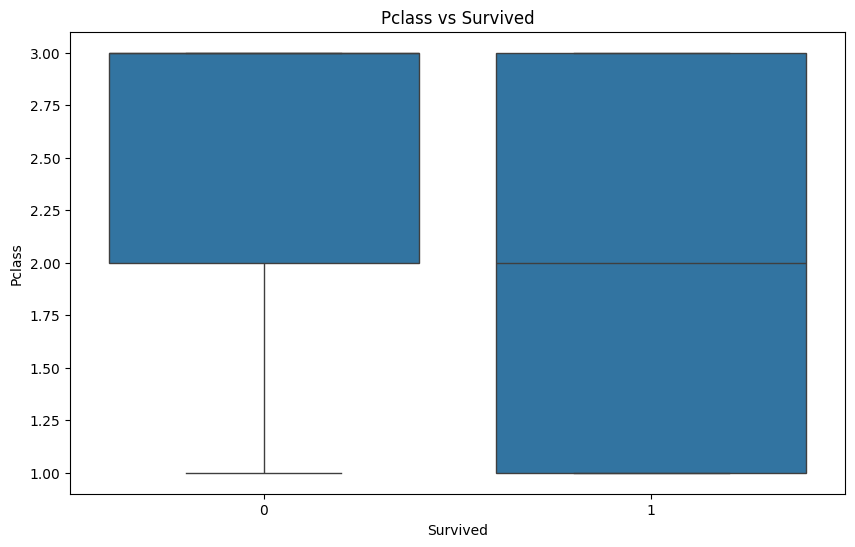

In [13]:
for column in train[corr_features].columns:
    if column != 'Survived':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Survived', y=column, data=train)
        plt.title(f'{column} vs Survived')
        plt.show()

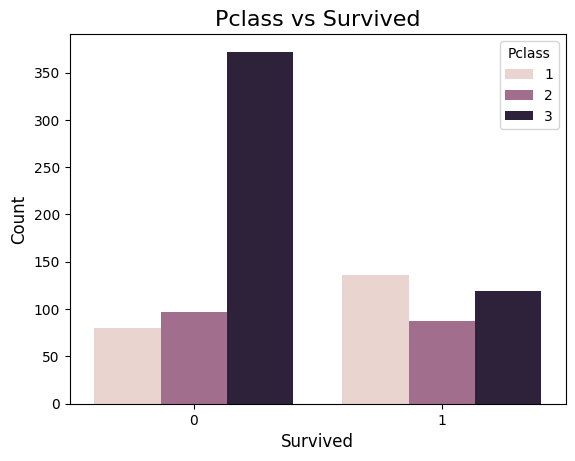

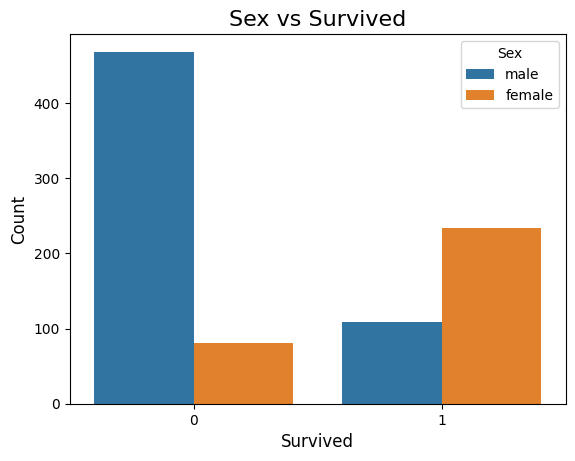

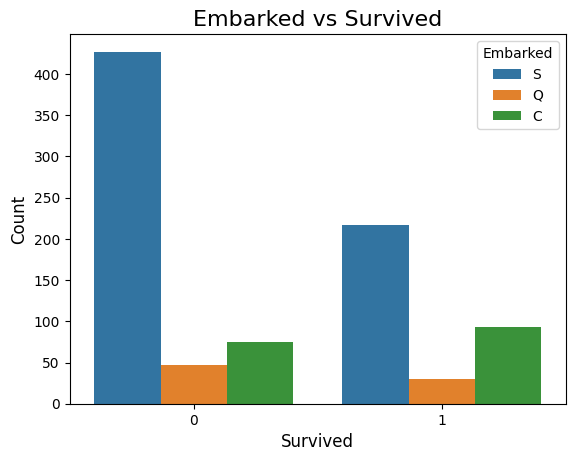

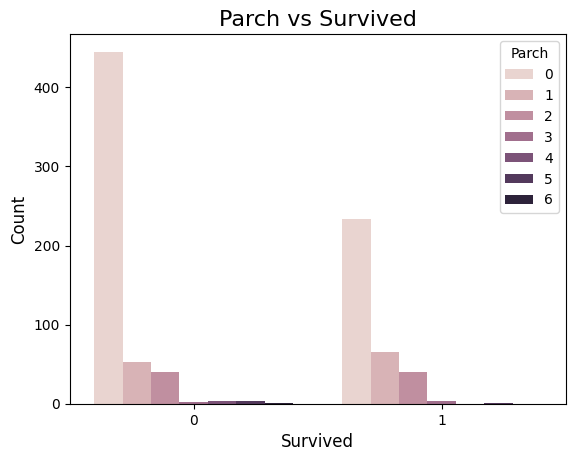

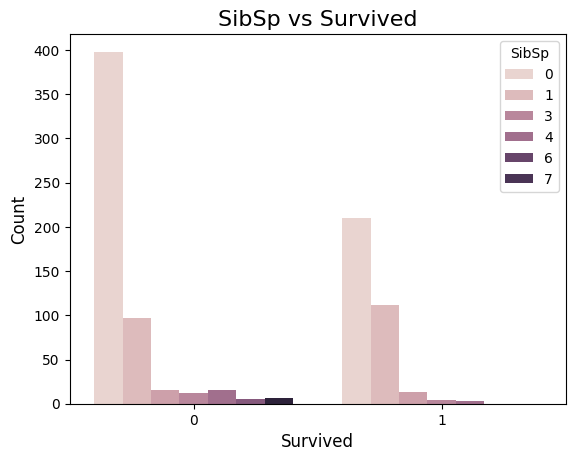

In [29]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Parch', 'SibSp']
for col in cat_features:
    sns.countplot(x='Survived', hue=col, data=train)
    plt.title(f'{col} vs Survived', fontsize=16)
    plt.xlabel('Survived', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=col)
    plt.show()

In [37]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Parch', 'SibSp', 'Parch_binary']

for col in cat_features:
    contingency_table = pd.crosstab(train[col], train['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'Chi-squared test for {col} vs Survived:')
        print(f"Chi-squared Statistic: {chi2}")
        print(f"P-value: {p}")
        print(f"Degrees of Freedom: {dof}")
        print(f"Expected Frequencies: \n{expected}")
        print('------------------------------------')
    else:
        print(f'{col} is not associated with Survived.')




Chi-squared test for Pclass vs Survived:
Chi-squared Statistic: 102.88898875696056
P-value: 4.549251711298793e-23
Degrees of Freedom: 2
Expected Frequencies: 
[[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]
------------------------------------
Chi-squared test for Sex vs Survived:
Chi-squared Statistic: 260.71702016732104
P-value: 1.1973570627755645e-58
Degrees of Freedom: 1
Expected Frequencies: 
[[193.47474747 120.52525253]
 [355.52525253 221.47474747]]
------------------------------------
Chi-squared test for Embarked vs Survived:
Chi-squared Statistic: 26.48914983923762
P-value: 1.769922284120912e-06
Degrees of Freedom: 2
Expected Frequencies: 
[[103.7480315  64.2519685]
 [ 47.5511811  29.4488189]
 [397.7007874 246.2992126]]
------------------------------------
Chi-squared test for Parch vs Survived:
Chi-squared Statistic: 27.925784060236168
P-value: 9.703526421039996e-05
Degrees of Freedom: 6
Expected Frequencies: 
[[4.17757576e+02 2.6024242

In [46]:
le = LabelEncoder()
parch_binary = le.fit_transform(train['Parch'])

parch_binary = (parch_binary != 0).astype(int)
train['Parch_binary'] = parch_binary

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [56]:
le = LabelEncoder()
binary = le.fit_transform(train['Sex'])

binary = (binary != 1).astype(int)
train['Female'] = binary

In [57]:
numerical_features = ['Age', 'SibSp', 'Fare', 'Pclass', 'Parch', 'Female']# 'Parch_binary']#, 'Parch']

scaler = StandardScaler()
scaled = scaler.fit_transform(train[numerical_features])

pca = PCA(n_components=2) 
pca.fit(scaled)

components = pca.components_

loadings = pd.DataFrame(components, columns=numerical_features)

importance = loadings.iloc[0].abs()  
importance = importance.sort_values(ascending=False)

print("\nFeature Importance for the First Principal Component:")
print(importance)


Feature Importance for the First Principal Component:
Fare      0.556745
Parch     0.480056
Female    0.399402
SibSp     0.392640
Pclass    0.379258
Age       0.045353
Name: 0, dtype: float64


We can see something really interesting for 'Parch' when we compare the heatmap to the boxplots: while the heatmap shows low correlation between 'Parch' and the target variable, the box plot seems to suggest a relationship. 

In [210]:
n_survived = train[train['Survived'] == 1].shape[0]
n_not_survived = train[train['Survived'] == 0].shape[0]
print(f'{round(n_survived / train.shape[0] * 100)}% of passengers survived.')

38% of passengers survived.


In [211]:
break_feature = 'Survived'
break_two_feature = 'Parch'
subset = train[train[break_feature] == 1]
n = subset.shape[0]

# for class_num in [1,]:
num_class_total = train[train[break_two_feature] == 0].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] == 0].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers did not have parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers did not have parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who did not have parents or children on board survived.')
print('------------------------------------')

num_class_total = train[train[break_two_feature] > 0].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] > 0].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers had parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers had parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who had parents or children on board survived.')
print('------------------------------------')

num_class_total = train[train[break_two_feature] > 1].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] > 1].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers had more than one parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers had more than one parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who had more than one parents or children on board survived.')
print('------------------------------------')

for class_num in range(1,7):
    num_class_total = train[train[break_two_feature] == class_num].shape[0]
    pct_of_total = num_class_total/train.shape[0]
    num_class_subset = subset[subset[break_two_feature] == class_num].shape[0]
    pct_class = num_class_subset/n
    pct_of_class = num_class_subset/num_class_total
    print(f'{round(pct_of_total*100)}% of passengers had {class_num} parents or children on board.')
    print(f'{round(pct_class*100)}% of surviving passengers had {class_num} parents or children on board.')
    print(f'{round(pct_of_class*100)}% of passengers who had {class_num} parents or children on board survived.')
    print('------------------------------------')

76% of passengers did not have parents or children on board.
68% of surviving passengers did not have parents or children on board.
34% of passengers who did not have parents or children on board survived.
------------------------------------
24% of passengers had parents or children on board.
32% of surviving passengers had parents or children on board.
51% of passengers who had parents or children on board survived.
------------------------------------
11% of passengers had more than one parents or children on board.
13% of surviving passengers had more than one parents or children on board.
46% of passengers who had more than one parents or children on board survived.
------------------------------------
13% of passengers had 1 parents or children on board.
19% of surviving passengers had 1 parents or children on board.
55% of passengers who had 1 parents or children on board survived.
------------------------------------
9% of passengers had 2 parents or children on board.
12% of s

Since survival rate was about the same for passengers who 1 to 3 parents or children on board (and very very few passengers had more than three parents or children on board), I think it makes sense to make 'Parch' into a binary [0='did not have children or parents', 1='had children or parents'] variable. 

In [ ]:
le = LabelEncoder()
parch_binary = le.fit_transform(train['Parch'])

parch_binary = (parch_binary != 0).astype(int)
train['Parch'] = parch_binary

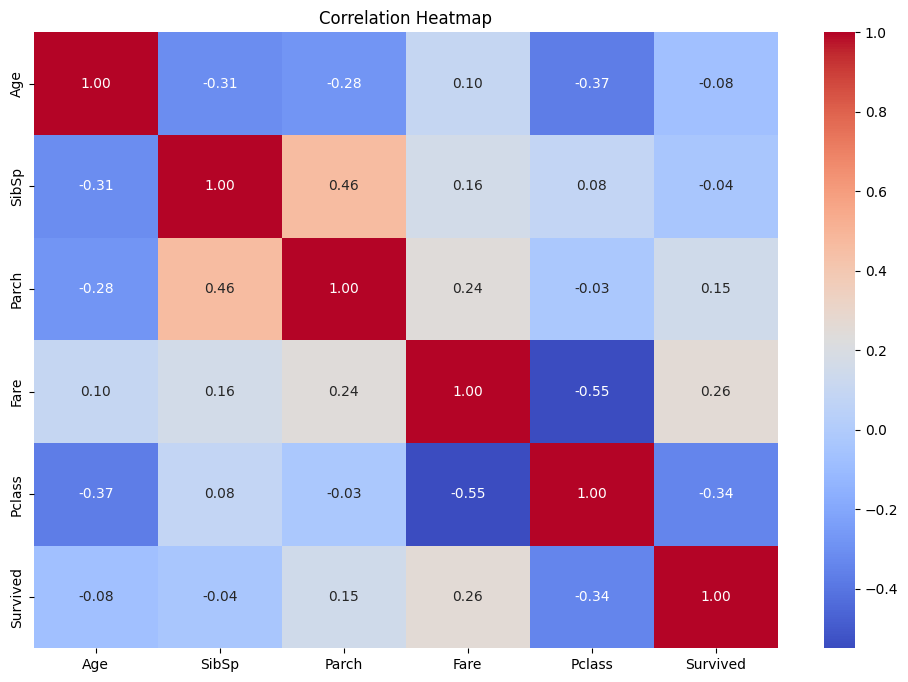

In [213]:
corr_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Survived']
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [214]:
break_feature = 'Survived'
break_two_feature = 'Pclass'
subset = train[train[break_feature] == 1]
n = subset.shape[0]

for class_num in range(1,4):
    num_class_total = train[train[break_two_feature] == class_num].shape[0]
    pct_of_total = num_class_total/train.shape[0]
    num_class_subset = subset[subset[break_two_feature] == class_num].shape[0]
    pct_class = num_class_subset/n
    pct_of_class = num_class_subset/num_class_total
    print(f'{round(pct_of_total*100)}% of passengers had class {class_num} tickets.')
    print(f'{round(pct_class*100)}% of surviving passengers had class {class_num} tickets.')
    print(f'{round(pct_of_class*100)}% of passengers with class {class_num} tickets survived.')
    print('------------------------------------')

24% of passengers had class 1 tickets.
40% of surviving passengers had class 1 tickets.
63% of passengers with class 1 tickets survived.
------------------------------------
21% of passengers had class 2 tickets.
25% of surviving passengers had class 2 tickets.
47% of passengers with class 2 tickets survived.
------------------------------------
55% of passengers had class 3 tickets.
35% of surviving passengers had class 3 tickets.
24% of passengers with class 3 tickets survived.
------------------------------------


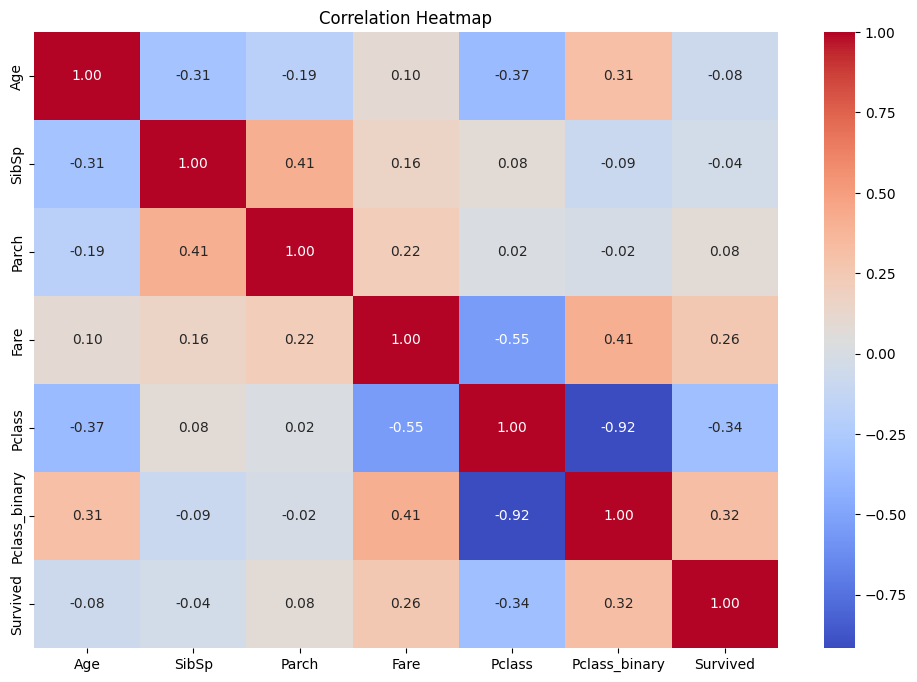

In [28]:
le = LabelEncoder()
feature = 'Pclass'
binary = le.fit_transform(train[feature])

binary = (binary != 2).astype(int)
train['Pclass_binary'] = binary


corr_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Pclass_binary', 'Survived']
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Since several of the features have minimal correlation with the target variable it might make sense to do PCA

### 2. Code and results for the model, including performance/accuracy on the training set and on your validation set.

### 3. A snapshot of the submission including your team name (as an individual, you’re a team of 1 person), as shown on the Kaggle leaderboard.

### 4. Commentary on the relative performance of your model, relative to that of other teams. It is not necessary to have a high performing model at this point, but you should have some idea about next steps for improving the model.

# Problem 2 - Classification Model 2:
---
Repeat Problem 1, but this time with a different model. It is sufficient to try
the same technique but with different hyperparameter values. However, you will
need to provide comments about the relative performance of your new model
compared to your Classification Model 1. Provide all of the information as listed
for Classification Model 1 (code, results, performance, etc.).

# Problem 3 - Classification Model 3:
---

Repeat Problem 1 yet again, but this time with a different model from either
Problem 1 or 2. You should be looking not for perfection, but for improvement
in accuracy on your validation set, and ultimately on your position on the
leaderboard (although this is not absolutely necessary). If you find the accuracy
going down, you should comment as to possible reasons why. Submit all code,
results, comments on relative performance as you did in Problem 2.

# Compiling Each Model’s Results for the Assignment:
---
Each student will submit a pdf document that shows their code, output, comments, visualizations etc.. This will be accomplished by building a IPython/Jupyter notebook to complete the assignment and then after completion, converting the document to pdf format.

As part of this assignment you will not only download the titanic dataset but
you’ll also join the competition (by clicking on the ”Join the Competition”
button on the Kaggle/Titanic webpage).

For each model, you’ll use the training dataset to train a model, but also esti-
mate the accuracy of your model. You’ll accomplish this by splitting the training
set (in the training file downloaded from Kaggle) into two subsets - an actual
training set on which you’ll train the model, and then a validation set (say, an
80/20 split, but that’s just a suggestion) on which you’ll run the trained model
to see how accurate it is. You’ll be able to get an accurate performance reading
as you’ll know what the actual results are for these records (they were part of
the original training set you downloaded).

Next, you’ll run your model on the actual test set data file you downloaded
from Kaggle. The label values (whether the passenger survived, 1 or 0), for
the records in the test file are not given. So, you are not able to determine the
accuracy of your model against the test set by simply running your model on
these records. Instead, you’ll submit the test file with your model’s predictions
for these passengers to Kaggle, where the platform will compare your model’s
predicted values with the acutal, (hidden) values to give you an accuracy score.
Note, you won’t be given the correct/incorrect breakdown of the individual test
records for your model - you’ll only see the overall accuracy score. It will be left
to you to take this coarse-grained accuracy info and think of ways to improve
your model.

After the Kaggle platform determines your model’s accuracy, it will post your
”team” name (since you’re each doing this individually, you each constitute a
team of 1, and you can name your team however you like), along with your
accuracy at the appropriate position on the leaderboard. Take a screenshot of
your team position on the leaderboard and include it for each of the 3 models
you develop as part of the assignment.

Figures 1, 2 and 3, below, show images of the Kaggle leaderboard, including
individual entrants, the number of submissions they’ve made, and the accuracy
of their last submission on the Kaggle test set.

Please understand I am not looking for you to have a 100% accuracy for any
of your models. The important aspect is after starting with a simple model,
you start thinking about ways to improve the model, record your reasoning
for making these changes, determining whether the model has improved after
submitting against the Kaggle test set, and providing further reasoning about
any change to performance (positive or negative).